This notebook processes experimental data of tracked GAG proteins during the formation of capsids

# Define parameters

In [1]:
### Parameters

## files
trajectory_file = 'vlp.txt'

## tessellation
# cell size
resolution = .1 # in um
# minimum numbers of locations per cell
min_n  =  1 # discard below (first)
min_nn = 10 # enlarge below (second)
# time window
win   = 180. # in s
shift =  15. # in s

## inference
sigma = .03 # in um
diffusivity_smoothing = 0.
potential_smoothing   = 1e-3
time_negligeable_smoothing = 1e-3 / potential_smoothing
time_smoothing        = 10. / potential_smoothing

## movie
frame_rate = 4 # segments per second


## automatic parameters

# files
import os.path
rwa_file = os.path.splitext(trajectory_file)[0]+'.rwa'

# label factories
seg_label = lambda n, nn, t: 'hexagon_res_{:.0f}_win_{:.0f}-{:.0f}_min_{:d}-{:d}_reg_{}'.format(round(resolution * 1e3), win, shift, n, nn, 1 if t else 0)
sdv_label = lambda t: 'sigma_{:.0f}_sdv_d_{:.0f}_v_{:.0f}_t_{:.0f}'.format(round(sigma * 1e3), diffusivity_smoothing, potential_smoothing, round(t*1e3))

# tessellate labels
for_density_label = seg_label(1, 0, 0)
for_sdv_label = seg_label(min_n, min_nn, 0)
for_smooth_sdv_label = seg_label(min_n, min_nn, 1)

# Tessellate and infer

In [2]:
from tramway.helper import *
import time

# tessellate common options
cell_sizing = dict(ref_distance=resolution, rel_avg_distance=1., min_location_count=0)
cell_adjust = dict(min_n=min_n, knn=min_nn)
time_segmentation = dict(time_window_duration=win, time_window_shift=shift)

if not os.path.exists(rwa_file):
    
    # segmentation for density estimation
    tessellate(trajectory_file, 'hexagon', output_file=rwa_file,
               **cell_sizing, # cell sizing
               **time_segmentation, # time segmentation
               output_label=for_density_label)
    
    # segmentation for dv inference without temporal smoothing
    tessellate(rwa_file, 'hexagon',
               **cell_sizing, # cell sizing
               **cell_adjust, # filter and adjust the smaller cells
               **time_segmentation, # time segmentation
               output_label=for_sdv_label)
    
    # segmentation for dv inference with temporal smoothing
    tessellate(rwa_file, 'hexagon',
               **cell_sizing, # cell sizing
               **cell_adjust, # filter and adjust the smaller cells
               **time_segmentation, enable_time_regularization=True, # time segmentation
               output_label=for_smooth_sdv_label)

# density
infer(rwa_file, 'density', input_label=for_density_label, output_label='density')

# infer common options
spatial_kwargs = dict(sigma=sigma, diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing)
optim_kwargs   = dict(ftol=1e-3)

# dv without temporal smoothing
t0 = time.time()
infer(rwa_file, 'stochastic.dv',
      **spatial_kwargs, time_prior=time_negligeable_smoothing,
      **optim_kwargs,
      input_label=for_smooth_sdv_label, output_label=sdv_label(0))
print('elapsed time: {:.0f}s'.format(round(time.time()-t0)))

# dv with temporal smoothing
assert 0 < time_smoothing
t0 = time.time()
infer(rwa_file, 'stochastic.dv',
      **spatial_kwargs, time_prior=time_smoothing,
      **optim_kwargs,
      input_label=for_smooth_sdv_label, output_label=sdv_label(time_smoothing))
print('elapsed time: {:.0f}s'.format(round(time.time()-t0)))

/home/francois/.local/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
gradV(9870) is not defined
gradV(9105) is not defined
gradV(25395) is not defined
gradV(26160) is not defined
gradV(24630) is not defined
gradV(7537) is not defined
gradV(23865) is not defined
gradV(23100) is not defined
gradV(6775) is not defined
gradV(6010) is not defined
gradV(14754) is not defined
gradV(13989) is not defined
gradV(15519) is not defined
gradV(25032) is not defined
gradV(24267) is not defined
gradV(25797) is not defined
gradV(4565) is not defined
gradV(3800) is not defined
gradV(5330) is not defined
gradV(22599) is not defined
gradV(21834) is not defined
gradV(19762) is not defined
gradV(21972) is n

elapsed time: 95830s


gradV(3025) is not defined
gradV(2260) is not defined
gradV(3790) is not defined
gradV(29985) is not defined
gradV(29220) is not defined
gradV(17948) is not defined
gradV(18713) is not defined
gradV(17183) is not defined
gradV(17738) is not defined
gradV(18503) is not defined
gradV(5694) is not defined
gradV(6459) is not defined
gradV(18508) is not defined
gradV(10501) is not defined
gradV(9736) is not defined
gradV(11266) is not defined
gradV(30817) is not defined
gradV(18123) is not defined
gradV(18888) is not defined
gradV(17358) is not defined
gradV(14754) is not defined
gradV(13989) is not defined
gradV(15519) is not defined
dV(30683)/dt failed
gradV(26925) is not defined
gradV(26160) is not defined
gradV(27690) is not defined
gradV(28455) is not defined
gradV(7537) is not defined
gradV(6772) is not defined
dV(30635)/dt failed
gradV(13533) is not defined
gradV(12768) is not defined
gradV(14298) is not defined
gradV(17244) is not defined
gradV(14444) is not defined
gradV(13679) is 

elapsed time: 37360s


# Create videos

In [4]:
from tramway.helper.animation import *
import os

# parameters
density_suffix =         '_n'
suffix = {'diffusivity': '_d',
          'potential':   '_v',
          'force':       '_f'}
verbose = True

# init
basename = os.path.splitext(rwa_file)[0]
movie_files = []
def grab(seg_label, map_label, feature, suffix):
    movie_file = '{}{}.mp4'.format(basename, suffix)
    movie_files.append(movie_file)
    animate_map_2d_helper(rwa_file,
                          movie_file,
                          label=[seg_label, map_label],
                          feature=feature,
                          frame_rate=frame_rate,
                          play=False, verbose=verbose)

# density
grab(for_density_label, 'density', 'density', density_suffix)

for feature in suffix:
    
    # dv without temporal smoothing
    grab(for_smooth_sdv_label, sdv_label(0), feature, suffix[feature])
    
    # dv with temporal smoothing
    _suffix = '_t{:.0f}{}'.format(round(time_smoothing), suffix[feature])
    grab(for_smooth_sdv_label, sdv_label(time_smoothing), feature, _suffix)
    
import matplotlib.pyplot
matplotlib.pyplot.close('all')
    
# movies to be opened with an external reader
print('''
In: {}
Generated files: {}'''.format(os.getcwd(), ', '.join(movie_files)))

overwrite file 'vlp_n.mp4': [N/y] y


100%|██████████| 41/41 [00:04<00:00,  8.66it/s]


overwrite file 'vlp_d.mp4': [N/y] y


100%|██████████| 41/41 [00:04<00:00,  9.09it/s]


overwrite file 'vlp_v.mp4': [N/y] y


100%|██████████| 41/41 [00:04<00:00, 10.28it/s]


overwrite file 'vlp_f.mp4': [N/y] y


100%|██████████| 41/41 [00:09<00:00,  5.79it/s]



In: /home/francois/github/COMPARE19/2. Gag protein
Generated files: vlp_n.mp4, vlp_d.mp4, vlp_t10000_d.mp4, vlp_v.mp4, vlp_t10000_v.mp4, vlp_f.mp4, vlp_t10000_f.mp4


## Watch the videos

In [5]:
from IPython.display import HTML

width, height = 480, 360

# density
HTML('''
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
'''.format(width, height, movie_files[0]))

In [6]:
from IPython.display import HTML

# diffusivity
HTML('''
<div style="white-space: no-wrap">
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
</div>
'''.format(width, height, movie_files[1], width, height, movie_files[4]))

# Access the inferred parameters

We are going to compare the time course of the potential energy at a selected cell.

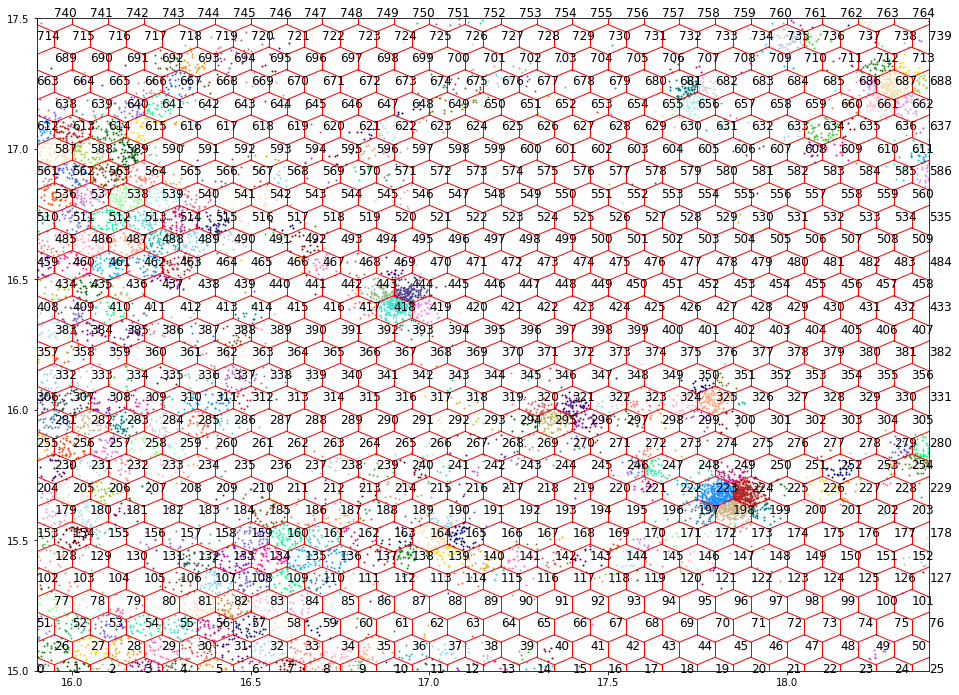

In [7]:
# load the file and pick and choose a cell
from tramway.helper import *
import matplotlib.pyplot as plt

analyses = load_rwa(rwa_file)

cell_plot(analyses, label=for_density_label, cell_indices=True, locations=dict(size=2), figsize=(16,12))

In [8]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# extract the potential energy maps
cells = analyses[for_smooth_sdv_label].data

maps  = analyses[for_smooth_sdv_label][sdv_label(0)].data
V     = maps['potential']
# remember: cells are replicated for each segments and cell indices do not match those above
V

,potential
0,4.820057
1,4.126084
2,2.834515
3,2.325330
4,2.161947
5,2.791892
6,2.883266
7,3.150067
8,2.662408
9,2.486622


In [9]:
seg_V = cells.tessellation.split_frames(V, return_times=True)
# now the maps corresponding to the different time segments have adequate indices
seg_V[0][1]

,potential
0,4.820057
1,4.126084
2,2.834515
3,2.325330
4,2.161947
5,2.791892
6,2.883266
7,3.150067
8,2.662408
9,2.486622


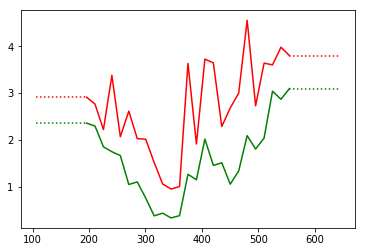

In [10]:
cell_index = 223

smooth_maps = analyses[for_smooth_sdv_label][sdv_label(time_smoothing)].data
smooth_V    = smooth_maps['potential']
smooth_V    = cells.tessellation.split_frames(smooth_V)

# complete the value extraction...
seg, t, v, smooth_v = [], [], [], []
for s in range(len(seg_V)):
    _seg, _v = seg_V[s]
    _smooth_v = smooth_V[s]
    try:
        _v = _v.loc[cell_index]
        _smooth_v = _smooth_v.loc[cell_index]
    except KeyError:
        continue
    else:
        seg.append(_seg)
        t.append((_seg[0] + _seg[1]) / 2)
        v.append(_v)
        smooth_v.append(_smooth_v)
t, v, smooth_v  = np.array(t), np.array(v), np.array(smooth_v)

# ... and plot
def plot(_v, _c):
    plt.plot([seg[0][0], t[0], None, t[-1], seg[-1][-1]], [_v[0], _v[0], None, _v[-1], _v[-1]], _c+':', linewidth=1.5)
    plt.plot(t, _v, _c+'-', linewidth=1.5)
    
plot(v, 'r')
plot(smooth_v, 'g')
plt.show()